# Transformation des Données - Analyse de la Criminalité

**Projet :** Données de Criminalité à Los Angeles (2020 - Présent)

**Objectif :** Transformer les données et créer de nouvelles variables pour enrichir l'analyse.

---

## Table des Matières
1. [Importer les Bibliothèques & Charger les Données](#1)
2. [Créer de Nouvelles Variables](#2)
3. [Filtrer et Sélectionner](#3)
4. [Fusionner les Données](#4)
5. [Pivoter et Remodeler](#5)
6. [Pipeline Automatique](#6)
7. [Résumé & Sauvegarder](#7)

## 1. Importer les Bibliothèques & Charger les Données <a id='1'></a>

On commence par importer les bibliothèques et charger nos données nettoyées.

In [1]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Pour mieux voir les résultats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Style des graphiques
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Bibliothèques importées !")

✓ Bibliothèques importées !


In [2]:
import pandas as pd

# Charger les données nettoyées
df = pd.read_csv('../data/Crime_Data_Cleaned.csv')
print("✓ Données nettoyées chargées !")

# Taille du dataset
print(f"Taille : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")

# Aperçu
print("\nAperçu des données :")
display(df.head())


✓ Données nettoyées chargées !
Taille : 50,000 lignes × 24 colonnes

Aperçu des données :


,numero_rapport,date_signalement,date_crime,heure_crime,code_zone,nom_zone,district,partie_crime,code_crime,description_crime,codes_modus,age_victime,sexe_victime,origine_victime,code_lieu,description_lieu,code_arme,description_arme,code_statut,description_statut,code_crime_1,localisation,latitude,longitude
0,200216570,2020-10-23,2020-10-01,2000,2,Rampart,249,2,956,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",1906 1820 0913,42,Female,White,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Unknown,AA,Adult Arrest,956.0,600 ST PAUL AV,34.0542,-118.2611
1,211009787,2021-07-04,2021-07-03,2250,10,West Valley,1011,2,354,THEFT OF IDENTITY,1822 0377,49,Male,White,101.0,STREET,NaN,Unknown,AA,Adult Arrest,354.0,ARMINTA,34.2047,-118.5531
2,201225286,2020-11-26,2020-11-26,1610,12,77th Street,1241,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1822 2021 0340 0334 0353 0445,35,Male,Black,108.0,PARKING LOT,102.0,HAND GUN,IC,Invest Cont,230.0,6400 WEST BL,33.9810,-118.3352
3,231614576,2023-12-01,2023-10-04,900,16,Foothill,1657,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0344,50,Female,Hispanic/Latin/Mexican,116.0,OTHER/OUTSIDE,NaN,Unknown,IC,Invest Cont,440.0,10100 HILLHAVEN AV,34.2523,-118.2898
4,221007431,2022-04-01,2022-03-31,1830,10,West Valley,1004,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),1822 0344,40,Male,Filipino,701.0,HOSPITAL,NaN,Unknown,IC,Invest Cont,420.0,18300 ROSCOE BL,34.2208,-118.5317


## 2. Créer de Nouvelles Variables <a id='2'></a>

On va créer plein de nouvelles colonnes utiles pour l'analyse.

### 2.1 Variables Temporelles

Extraire des infos sur les dates et les heures.

In [3]:
print("=" * 80)
print("CRÉATION DES VARIABLES TEMPORELLES")
print("=" * 80)

# Détection des noms de colonnes
col_date_signal = 'date_signalement' if 'date_signalement' in df.columns else 'Date Rptd'
col_date_crime  = 'date_crime' if 'date_crime' in df.columns else 'DATE OCC'
col_heure_crime = 'heure_crime' if 'heure_crime' in df.columns else 'TIME OCC'
print(f"✓ Colonnes utilisées : {col_date_signal}, {col_date_crime}, {col_heure_crime}")

# Conversion en datetime
df[col_date_signal] = pd.to_datetime(df[col_date_signal], errors='coerce')
df[col_date_crime]  = pd.to_datetime(df[col_date_crime], errors='coerce')

# Extraction des informations de date
df['annee'] = df[col_date_crime].dt.year
df['mois'] = df[col_date_crime].dt.month
df['nom_mois'] = df[col_date_crime].dt.month_name()
df['jour'] = df[col_date_crime].dt.day
df['numero_jour_semaine'] = df[col_date_crime].dt.dayofweek
df['nom_jour'] = df[col_date_crime].dt.day_name()
df['trimestre'] = df[col_date_crime].dt.quarter
df['semaine_annee'] = df[col_date_crime].dt.isocalendar().week

# Fonction pour catégoriser les périodes de la journée
def periode_journee(heure):
    if pd.isna(heure):
        return 'Inconnu'
    elif 0 <= heure < 6:
        return 'Nuit (00h-06h)'
    elif 6 <= heure < 12:
        return 'Matin (06h-12h)'
    elif 12 <= heure < 18:
        return 'Après-midi (12h-18h)'
    else:
        return 'Soirée (18h-00h)'

# Extraire heure et minute depuis TIME OCC (format 2330)
df['heure'] = pd.to_numeric(df[col_heure_crime], errors='coerce').apply(lambda x: int(x // 100) if not pd.isna(x) else None)
df['minute'] = pd.to_numeric(df[col_heure_crime], errors='coerce').apply(lambda x: int(x % 100) if not pd.isna(x) else None)
df['periode_jour'] = df['heure'].apply(periode_journee)

# Calculer le délai de signalement
df['delai_signalement'] = (df[col_date_signal] - df[col_date_crime]).dt.days

# Indicateur weekend
df['est_weekend'] = df['numero_jour_semaine'].apply(lambda x: 1 if x >= 5 else 0)

print("✓ Variables temporelles créées :")
print(f"   - Année, Mois, Jour, Trimestre, Semaine")
print(f"   - Jour de la semaine, Indicateur weekend")
print(f"   - Heure, Période du jour")
print(f"   - Délai de signalement")

# Aperçu
cols_apercu = [col_date_crime, 'annee', 'nom_mois', 'nom_jour', 'heure', 
               'periode_jour', 'est_weekend', 'delai_signalement']
df[cols_apercu].head(10)


CRÉATION DES VARIABLES TEMPORELLES
✓ Colonnes utilisées : date_signalement, date_crime, heure_crime
✓ Variables temporelles créées :
   - Année, Mois, Jour, Trimestre, Semaine
   - Jour de la semaine, Indicateur weekend
   - Heure, Période du jour
   - Délai de signalement


,date_crime,annee,nom_mois,nom_jour,heure,periode_jour,est_weekend,delai_signalement
0,2020-10-01,2020,October,Thursday,20,Soirée (18h-00h),0,22
1,2021-07-03,2021,July,Saturday,22,Soirée (18h-00h),1,1
2,2020-11-26,2020,November,Thursday,16,Après-midi (12h-18h),0,0
3,2023-10-04,2023,October,Wednesday,9,Matin (06h-12h),0,58
4,2022-03-31,2022,March,Thursday,18,Soirée (18h-00h),0,1
5,2024-02-29,2024,February,Thursday,21,Soirée (18h-00h),0,0
6,2021-09-21,2021,September,Tuesday,13,Après-midi (12h-18h),0,0
7,2021-08-18,2021,August,Wednesday,14,Après-midi (12h-18h),0,0
8,2023-08-08,2023,August,Tuesday,14,Après-midi (12h-18h),0,6
9,2024-11-29,2024,November,Friday,16,Après-midi (12h-18h),0,4


### 2.2 Catégories de Crimes

Créer des catégories pour mieux analyser les crimes.

In [4]:
print("\n" + "=" * 80)
print("CRÉATION DES CATÉGORIES DE CRIMES")
print("=" * 80)

# Détecter les noms de colonnes
col_partie = 'partie_crime' if 'partie_crime' in df.columns else 'Part 1-2'
col_desc_crime = 'description_crime' if 'description_crime' in df.columns else 'Crm Cd Desc'
col_desc_arme = 'description_arme' if 'description_arme' in df.columns else 'Weapon Desc'

# 1️⃣ Sévérité du crime (Partie 1 = grave, Partie 2 = moins grave)
df['severite_crime'] = df[col_partie].map({1: 'Partie 1 - Crime Grave', 2: 'Partie 2 - Crime Moins Grave'})

# 2️⃣ Catégorisation des crimes
def categoriser_crime(desc):
    if pd.isna(desc):
        return 'Inconnu'
    desc = str(desc).upper()
    if any(m in desc for m in ['ASSAULT', 'BATTERY', 'HOMICIDE', 'MURDER', 'RAPE', 'KIDNAPPING', 'THREATENING']):
        return 'Crime Violent'
    elif any(m in desc for m in ['THEFT', 'BURGLARY', 'ROBBERY', 'STOLEN', 'SHOPLIFTING', 'EMBEZZLEMENT']):
        return 'Vol/Cambriolage'
    elif any(m in desc for m in ['VEHICLE', 'AUTO', 'CAR', 'MOTORCYCLE']):
        return 'Lié aux Véhicules'
    elif any(m in desc for m in ['FRAUD', 'IDENTITY', 'FORGERY', 'CREDIT CARD']):
        return 'Fraude/Financier'
    elif 'VANDALISM' in desc:
        return 'Vandalisme'
    elif any(m in desc for m in ['DRUG', 'NARCOTIC', 'MARIJUANA']):
        return 'Lié à la Drogue'
    elif any(m in desc for m in ['WEAPON', 'FIREARM', 'GUN']):
        return 'Armes'
    else:
        return 'Autre'

df['categorie_crime'] = df[col_desc_crime].apply(categoriser_crime)

# 3️⃣ Indicateur si arme impliquée
df['arme_impliquee'] = df[col_desc_arme].notna() & (df[col_desc_arme] != '')
df['arme_impliquee'] = df['arme_impliquee'].astype(int)  # Convertir en 0/1

# 4️⃣ Catégorisation des types d'armes
def categoriser_arme(arme):
    if pd.isna(arme) or arme == '':
        return "Pas d'arme"
    arme_str = str(arme).upper()
    if any(m in arme_str for m in ['GUN', 'FIREARM', 'PISTOL', 'REVOLVER', 'RIFLE']):
        return 'Arme à feu'
    elif any(m in arme_str for m in ['KNIFE', 'BLADE', 'SWORD', 'MACHETE']):
        return 'Couteau/Lame'
    elif any(m in arme_str for m in ['STRONG-ARM', 'HANDS', 'FIST']):
        return 'Force physique'
    elif any(m in arme_str for m in ['VERBAL', 'THREAT']):
        return 'Menace verbale'
    elif 'VEHICLE' in arme_str:
        return 'Véhicule'
    else:
        return 'Autre arme'

df['type_arme'] = df[col_desc_arme].apply(categoriser_arme)

# ✅ Résumé
print("✓ Catégories de crimes créées :")
print("   - Sévérité (Partie 1/2)")
print("   - Catégorie de crime (Violent, Vol, etc.)")
print("   - Indicateur arme impliquée")
print("   - Type d'arme")

# Aperçu
print("\nDistribution des catégories de crimes :")
print(df['categorie_crime'].value_counts())
print("\nDistribution des types d'armes :")
print(df['type_arme'].value_counts())



CRÉATION DES CATÉGORIES DE CRIMES
✓ Catégories de crimes créées :
   - Sévérité (Partie 1/2)
   - Catégorie de crime (Violent, Vol, etc.)
   - Indicateur arme impliquée
   - Type d'arme

Distribution des catégories de crimes :
categorie_crime
Vol/Cambriolage      28870
Crime Violent        10458
Vandalisme            4379
Autre                 4376
Armes                 1819
Lié aux Véhicules       98
Name: count, dtype: int64

Distribution des types d'armes :
type_arme
Autre arme        36935
Force physique     8706
Arme à feu         1980
Menace verbale     1201
Couteau/Lame       1011
Véhicule            167
Name: count, dtype: int64


### 2.3 Infos sur les Victimes et les Lieux

Transformer les informations sur les victimes et les endroits.

In [5]:
print("\n" + "=" * 80) 
print("CRÉATION DES VARIABLES SUR LES VICTIMES ET LES LIEUX")
print("=" * 80)

# Colonnes selon existence
col_age_vict = 'age_victime' if 'age_victime' in df.columns else 'Vict Age'
col_desc_lieu = 'description_lieu' if 'description_lieu' in df.columns else 'Premis Desc'
col_dr_no = 'numero_rapport' if 'numero_rapport' in df.columns else 'DR_NO'
col_nom_zone = 'nom_zone' if 'nom_zone' in df.columns else 'AREA NAME'

# Catégorisation âge
bins = [0, 12, 17, 24, 34, 49, 64, float('inf')]
labels = ['Enfant (0-12)', 'Adolescent (13-17)', 'Jeune Adulte (18-24)',
          'Adulte (25-34)', 'Âge Moyen (35-49)', 'Senior (50-64)', 'Âgé (65+)']
df['groupe_age_victime'] = pd.cut(df[col_age_vict], bins=bins, labels=labels, right=True)
df['groupe_age_victime'] = df['groupe_age_victime'].cat.add_categories('Inconnu').fillna('Inconnu')

# Catégorisation lieu
def categoriser_lieu(lieu):
    if pd.isna(lieu):
        return 'Inconnu'
    lieu_str = str(lieu).upper()
    mapping = {
        'Rue Publique': ['STREET', 'SIDEWALK', 'ALLEY', 'HIGHWAY'],
        'Résidentiel': ['DWELLING', 'RESIDENCE', 'HOUSE', 'APARTMENT'],
        'Commercial': ['STORE', 'SHOP', 'MARKET', 'MALL', 'RESTAURANT'],
        'Stationnement': ['PARKING', 'GARAGE', 'LOT'],
        'Éducatif': ['SCHOOL', 'UNIVERSITY', 'COLLEGE'],
        'Financier': ['BANK', 'ATM'],
        'Récréatif': ['PARK', 'PLAYGROUND', 'BEACH'],
        'Religieux': ['CHURCH', 'TEMPLE', 'MOSQUE'],
        'Véhicule': ['VEHICLE']
    }
    for cat, mots in mapping.items():
        if any(m in lieu_str for m in mots):
            return cat
    return 'Autre'

df['type_lieu'] = df[col_desc_lieu].apply(categoriser_lieu)

# Fréquence et score de risque par zone
df['frequence_crimes_zone'] = df.groupby(col_nom_zone)[col_dr_no].transform('count')
df['score_risque_zone'] = (df['frequence_crimes_zone'] / df['frequence_crimes_zone'].max() * 100).round(2)

print("✓ Variables victimes & lieux créées")



CRÉATION DES VARIABLES SUR LES VICTIMES ET LES LIEUX
✓ Variables victimes & lieux créées


## 3. Filtrer et Sélectionner les Données <a id='3'></a>

On va apprendre à filtrer les données avec différentes méthodes.

### 3.1 Exemples de Filtrage

In [6]:
print("=" * 80)
print("FILTRAGE DES DONNÉES")
print("=" * 80)

# Colonnes selon existence
col_date = 'date_crime' if 'date_crime' in df.columns else 'DATE OCC'
col_desc_crime = 'description_crime' if 'description_crime' in df.columns else 'Crm Cd Desc'
col_zone = 'nom_zone' if 'nom_zone' in df.columns else 'AREA NAME'

# Fonction générique pour filtrer et afficher un sous-ensemble
def filtrer_et_afficher(df, conditions, colonnes_affichage, description):
    """
    Filtre le DataFrame selon conditions et affiche un aperçu.
    
    conditions : boolean Series ou string pour df.query()
    colonnes_affichage : liste des colonnes à afficher
    description : texte descriptif pour l'affichage
    """
    subset = df.query(conditions) if isinstance(conditions, str) else df[conditions]
    print(f"\n{description} : {len(subset):,} enregistrements")
    print(subset[colonnes_affichage].head())
    return subset

# 1. Crimes violents en 2024
crimes_violents_2024 = filtrer_et_afficher(
    df,
    (df['categorie_crime'] == 'Crime Violent') & (df['annee'] == 2024),
    [col_date, col_desc_crime, col_zone, 'groupe_age_victime'],
    "1. Crimes Violents en 2024"
)

# 2. Crimes avec armes le weekend
crimes_armes_weekend = filtrer_et_afficher(
    df,
    (df['arme_impliquee'] == 1) & (df['est_weekend'] == 1),
    ['nom_jour', col_desc_crime, 'type_arme', col_zone],
    "2. Crimes avec Armes le Weekend"
)

# 3. Vols dans zones à haut risque
haut_risque_vols = filtrer_et_afficher(
    df,
    (df['score_risque_zone'] > 50) & (df['categorie_crime'] == 'Vol/Cambriolage'),
    [col_zone, 'score_risque_zone', col_desc_crime, 'type_lieu'],
    "3. Vols dans Zones à Haut Risque"
)

# 4. Crimes du soir contre personnes âgées
ages_soir = filtrer_et_afficher(
    df,
    (df['periode_jour'] == 'Soirée (18h-00h)') & 
    (df['groupe_age_victime'] == 'Âgé (65+)') &
    (df['severite_crime'] == 'Partie 1 - Crime Grave'),
    [col_date, 'periode_jour', 'groupe_age_victime', col_desc_crime],
    "4. Crimes Graves du Soir Contre Âgés"
)

# 5. Filtrage avec query()
resultat_query = filtrer_et_afficher(
    df,
    'annee >= 2023 & arme_impliquee == 1 & est_weekend == 0',
    [col_date, 'nom_jour', 'type_arme', col_desc_crime],
    "5. Crimes avec Armes en Semaine (2023+)"
)


FILTRAGE DES DONNÉES

1. Crimes Violents en 2024 : 756 enregistrements
    date_crime                               description_crime     nom_zone  \
5   2024-02-29               INTIMATE PARTNER - SIMPLE ASSAULT      Rampart   
66  2024-02-28                        BATTERY - SIMPLE ASSAULT      Central   
234 2024-01-01  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    Southeast   
264 2024-01-01                        BATTERY - SIMPLE ASSAULT      Olympic   
351 2024-03-18           INTIMATE PARTNER - AGGRAVATED ASSAULT  77th Street   

    groupe_age_victime  
5       Adulte (25-34)  
66   Âge Moyen (35-49)  
234  Âge Moyen (35-49)  
264     Adulte (25-34)  
351     Adulte (25-34)  

2. Crimes avec Armes le Weekend : 14,320 enregistrements
    nom_jour                               description_crime   type_arme  \
1   Saturday                               THEFT OF IDENTITY  Autre arme   
13  Saturday  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  Arme à feu   
14    Sunday      

### 3.2 Utiliser loc[] et iloc[]

In [7]:
print("\n" + "=" * 80)
print("FILTRAGE AVEC LOC[] ET ILOC[]")
print("=" * 80)

# Colonnes selon existence
col_date = 'date_crime' if 'date_crime' in df.columns else 'DATE OCC'
col_desc_crime = 'description_crime' if 'description_crime' in df.columns else 'Crm Cd Desc'
col_zone = 'nom_zone' if 'nom_zone' in df.columns else 'AREA NAME'
col_statut = 'description_statut' if 'description_statut' in df.columns else 'Status Desc'

# Fonction générique pour afficher un sous-ensemble
def afficher_sous_ensemble(df_subset, description):
    print(f"\n{description} : {len(df_subset):,} enregistrements")
    print(df_subset.head())
    return df_subset

# 1. loc[] - Sélection par labels
sous_ensemble_violent = afficher_sous_ensemble(
    df.loc[df['categorie_crime'] == 'Crime Violent', 
           [col_date, col_desc_crime, col_zone, 'type_arme', col_statut]],
    "1. Avec loc[] - Crimes Violents"
)

# 2. loc[] - Plusieurs conditions
zones_specifiques = ['Central', 'Hollywood', 'Wilshire']
sous_ensemble_2024 = afficher_sous_ensemble(
    df.loc[(df['annee'] == 2024) & (df[col_zone].isin(zones_specifiques)),
           [col_date, col_zone, col_desc_crime, 'categorie_crime']],
    "2. Avec loc[] - Crimes 2024 dans zones spécifiques"
)

# 3. iloc[] - Sélection par position
sous_ensemble_position = afficher_sous_ensemble(
    df.iloc[:10, [1, 2, 3, 8, 9]],
    "3. Avec iloc[] - 10 premières lignes, colonnes spécifiques"
)

# 4. iloc[] - Échantillon chaque 100ème ligne
echantillon_donnees = afficher_sous_ensemble(
    df.iloc[::100, :],
    "4. Avec iloc[] - Chaque 100ème enregistrement"
)
print(echantillon_donnees[[col_date, col_desc_crime, col_zone]].head())

# 5. Combiner loc[] et iloc[] - Derniers 1000 crimes violents
indices_violents = df[df['categorie_crime'] == 'Crime Violent'].index
derniers_1000_violents = afficher_sous_ensemble(
    df.loc[indices_violents[-1000:], 
           [col_date, col_desc_crime, 'groupe_age_victime', 'type_arme']],
    "5. Derniers 1000 crimes violents, colonnes spécifiques"
)



FILTRAGE AVEC LOC[] ET ILOC[]

1. Avec loc[] - Crimes Violents : 10,458 enregistrements
   date_crime                               description_crime     nom_zone  \
2  2020-11-26  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  77th Street   
5  2024-02-29               INTIMATE PARTNER - SIMPLE ASSAULT      Rampart   
7  2021-08-18               INTIMATE PARTNER - SIMPLE ASSAULT      Rampart   
13 2023-01-14  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT      Rampart   
22 2023-02-19         CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT    Southeast   

         type_arme description_statut  
2       Arme à feu        Invest Cont  
5   Force physique        Invest Cont  
7   Force physique        Invest Cont  
13      Arme à feu        Invest Cont  
22  Force physique        Invest Cont  

2. Avec loc[] - Crimes 2024 dans zones spécifiques : 1,123 enregistrements
    date_crime   nom_zone                                description_crime  \
9   2024-11-29  Hollywood               THEFT PL

## 4. Fusionner et Concaténer <a id='4'></a>

On va apprendre à combiner plusieurs datasets ensemble.

### 4.1 Créer des Données Supplémentaires

Créer d'autres datasets pour montrer comment fusionner.

In [14]:
print("=" * 80)
print("CRÉER DES DATASETS SUPPLÉMENTAIRES POUR FUSION")
print("=" * 80)

# Dataset démographique (inchangé)
donnees_demographiques = pd.DataFrame({
    'AREA NAME': ['Central', 'Rampart', 'Southwest', 'Hollenbeck', 'Harbor',
                  'Hollywood', 'Wilshire', 'West LA', 'Van Nuys', 'West Valley',
                  'Northeast', '77th Street', 'Newton', 'Pacific', 'N Hollywood',
                  'Foothill', 'Devonshire', 'Southeast', 'Mission', 'Olympic',
                  'Topanga'],
    'population': [54000, 61000, 58000, 52000, 46000,
                   78000, 72000, 65000, 68000, 70000,
                   55000, 51000, 49000, 47000, 64000,
                   60000, 62000, 53000, 59000, 66000, 48000],
    'revenu_median': [45000, 38000, 42000, 35000, 52000,
                      68000, 85000, 95000, 55000, 62000,
                      48000, 32000, 30000, 75000, 50000,
                      58000, 72000, 36000, 44000, 52000, 88000],
    'taille_zone_miles_carres': [5.2, 6.8, 7.1, 6.3, 8.5,
                                 7.9, 6.4, 5.8, 9.2, 10.1,
                                 6.7, 8.3, 5.9, 7.5, 8.8,
                                 9.5, 11.2, 7.7, 8.9, 6.2, 12.5]
})
print("\n✓ Dataset démographique créé:")
print(donnees_demographiques.head(10))

# Colonnes correctes dans notre dataset
col_nom_zone = 'nom_zone'           # pour la zone
col_statut_desc = 'description_statut'  # pour le statut
col_numero_dr = 'numero_rapport'    # pour le DR
col_trimestre = 'trimestre'         # trimestre (à créer si nécessaire)

# Créer 'trimestre' si non existant
if col_trimestre not in df.columns:
    df['date_crime'] = pd.to_datetime(df['date_crime'], errors='coerce')
    df[col_trimestre] = df['date_crime'].dt.quarter.fillna(0).astype('int8')

# Stats de résolution
invest_flag = df[col_statut_desc].astype(str).str.contains('invest', case=False, na=False)
stats_resolution = df.assign(invest_cont=invest_flag).groupby(col_nom_zone).agg(
    taux_resolution=('invest_cont', 'mean'),
    total_cas=(col_numero_dr, 'count')
).reset_index()
stats_resolution['taux_resolution'] = (stats_resolution['taux_resolution']*100).round(2)

# Renommer la colonne pour correspondre au format standard
stats_resolution = stats_resolution.rename(columns={col_nom_zone: 'AREA NAME'})

print("\n✓ Statistiques de résolution créées:")
print(stats_resolution.head(10))

# Patterns saisonniers
donnees_saison = df.groupby([col_nom_zone, col_trimestre]).size().reset_index(name='comptage_crimes')
donnees_saisonnieres = donnees_saison.pivot(index=col_nom_zone, columns=col_trimestre, values='comptage_crimes').fillna(0)
donnees_saisonnieres.columns = [f'T{int(c)}_crimes' for c in donnees_saisonnieres.columns]
donnees_saisonnieres = donnees_saisonnieres.reset_index().rename(columns={col_nom_zone: 'AREA NAME'})

print("\n✓ Patterns saisonniers créés:")
print(donnees_saisonnieres.head())

CRÉER DES DATASETS SUPPLÉMENTAIRES POUR FUSION

✓ Dataset démographique créé:
     AREA NAME  population  revenu_median  taille_zone_miles_carres
0      Central       54000          45000                       5.2
1      Rampart       61000          38000                       6.8
2    Southwest       58000          42000                       7.1
3   Hollenbeck       52000          35000                       6.3
4       Harbor       46000          52000                       8.5
5    Hollywood       78000          68000                       7.9
6     Wilshire       72000          85000                       6.4
7      West LA       65000          95000                       5.8
8     Van Nuys       68000          55000                       9.2
9  West Valley       70000          62000                      10.1

✓ Statistiques de résolution créées:
     AREA NAME  taux_resolution  total_cas
0  77th Street            75.25       3059
1      Central            86.65       3454
2   Dev

In [15]:
# Détecter la bonne colonne de description
if 'crime_description' in df.columns:
    col_description_crime = 'crime_description'
elif 'categorie_crime' in df.columns:
    col_description_crime = 'categorie_crime'
elif 'description_crime' in df.columns:
    col_description_crime = 'description_crime'
elif 'Crm Cd Desc' in df.columns:
    col_description_crime = 'Crm Cd Desc'
else:
    raise KeyError("Impossible de trouver la colonne de description du crime.")


### 4.2 Opérations de Fusion

Montrer différentes stratégies de fusion.

In [16]:
print("\n" + "=" * 80)
print("FUSIONNER LES DATASETS")
print("=" * 80)

# Renommer nom_zone pour correspondre aux datasets à fusionner
if 'nom_zone' in df.columns:
    df['AREA NAME'] = df['nom_zone']

# Détecter le nom de la colonne description (important pour l'affichage après fusion)
if 'crime_description' in df.columns:
    col_description_crime = 'crime_description'
elif 'categorie_crime' in df.columns:
    col_description_crime = 'categorie_crime'
elif 'description_crime' in df.columns:
    col_description_crime = 'description_crime'
elif 'Crm Cd Desc' in df.columns:
    col_description_crime = 'Crm Cd Desc'
else:
    # Fallback sur la première colonne qui pourrait correspondre
    col_description_crime = 'categorie_crime'

print(f"✓ Colonne de description utilisée : {col_description_crime}")

# Fonction pour fusionner et afficher résumé
def fusionner_et_resumer(df_base, df_to_merge, on_col='AREA NAME', how='left', new_cols=None, desc=''):
    df_fusion = df_base.merge(df_to_merge, on=on_col, how=how)
    print(f"\n{desc}")
    print(f"   Lignes avant: {len(df_base):,}")
    print(f"   Lignes après fusion: {len(df_fusion):,}")
    if new_cols:
        print(f"   Colonnes ajoutées: {new_cols}")
    return df_fusion

# 1. Fusion INNER - Données démographiques
donnees_avec_demo = fusionner_et_resumer(
    df, 
    donnees_demographiques, 
    how='inner', 
    new_cols=list(donnees_demographiques.columns[1:]),
    desc="1. Fusion INNER - Données crimes avec démographie"
)
print(donnees_avec_demo[['AREA NAME', col_description_crime, 'population', 'revenu_median']].head())


# 2. Fusion LEFT - Statistiques de résolution
donnees_enrichies = fusionner_et_resumer(
    donnees_avec_demo, 
    stats_resolution, 
    how='left', 
    new_cols=['taux_resolution', 'total_cas'],
    desc="2. Fusion LEFT - Ajouter stats de résolution"
)
print(donnees_enrichies[['AREA NAME', col_description_crime, 'taux_resolution']].head())

# 3. Fusion LEFT - Données saisonnières
donnees_completes = fusionner_et_resumer(
    donnees_enrichies, 
    donnees_saisonnieres, 
    how='left', 
    new_cols=[col for col in donnees_saisonnieres.columns if col != 'AREA NAME'],
    desc="3. Fusion LEFT - Ajouter patterns saisonniers"
)
# Calcul des crimes par habitant
donnees_completes['crimes_par_1000'] = (donnees_completes['total_cas'] / donnees_completes['population'] * 1000).round(2)

print("\n✓ Dataset enrichi créé avec toutes les fusions")
print(f"   Forme finale: {donnees_completes.shape}")

# Aperçu final
print("\nÉchantillon des données enrichies:")
print(donnees_completes[['AREA NAME', 'categorie_crime', 'population', 'revenu_median', 
                         'taux_resolution', 'crimes_par_1000']].head(10))


FUSIONNER LES DATASETS
✓ Colonne de description utilisée : categorie_crime

1. Fusion INNER - Données crimes avec démographie
   Lignes avant: 50,000
   Lignes après fusion: 50,000
   Colonnes ajoutées: ['population', 'revenu_median', 'taille_zone_miles_carres']
     AREA NAME  categorie_crime  population  revenu_median
0      Rampart            Autre       61000          38000
1  West Valley  Vol/Cambriolage       70000          62000
2  77th Street    Crime Violent       51000          32000
3     Foothill  Vol/Cambriolage       60000          58000
4  West Valley  Vol/Cambriolage       70000          62000

2. Fusion LEFT - Ajouter stats de résolution
   Lignes avant: 50,000
   Lignes après fusion: 50,000
   Colonnes ajoutées: ['taux_resolution', 'total_cas']
     AREA NAME  categorie_crime  taux_resolution
0      Rampart            Autre            77.78
1  West Valley  Vol/Cambriolage            72.65
2  77th Street    Crime Violent            75.25
3     Foothill  Vol/Cambriolag

### 4.3 Concaténation

Combiner les datasets verticalement et horizontalement.

In [18]:
print("\n" + "=" * 80)
print("OPÉRATIONS DE CONCATÉNATION")
print("=" * 80)

# 1. Concaténation verticale - Diviser par année et recombiner
print("\n1. CONCATÉNATION VERTICALE - Diviser par année:")
donnees_2020 = donnees_completes[donnees_completes['annee'] == 2020].copy()
donnees_2021 = donnees_completes[donnees_completes['annee'] == 2021].copy()
donnees_2022 = donnees_completes[donnees_completes['annee'] == 2022].copy()

print(f"   2020: {len(donnees_2020):,} lignes")
print(f"   2021: {len(donnees_2021):,} lignes")
print(f"   2022: {len(donnees_2022):,} lignes")

# Concat vertical (empiler les années)
donnes_concat_vertical = pd.concat([donnees_2020, donnees_2021, donnees_2022], axis=0, ignore_index=True)
print(f"   Combiné: {len(donnes_concat_vertical):,} lignes")

# 2. Concaténation horizontale - Ajouter statistiques
print("\n2. CONCATÉNATION HORIZONTALE - Ajouter stats crimes:")

# Détecter les noms de colonnes qui existent dans donnees_completes
col_numero_dr = None
for possible_col in ['numero_rapport', 'DR_NO', 'dr_number']:
    if possible_col in donnees_completes.columns:
        col_numero_dr = possible_col
        break

if col_numero_dr is None:
    # Si aucune colonne DR n'est trouvée, utiliser l'index comme compteur
    print("   ⚠ Colonne DR_NO introuvable, utilisation de l'index pour le comptage")
    stats_zones = donnees_completes.groupby('AREA NAME').agg({
        'arme_impliquee': ['sum', 'count'],
        'est_weekend': 'sum'
    })
    stats_zones.columns = ['crimes_arme_zone', 'total_crimes_zone', 'crimes_weekend_zone']
    stats_zones = stats_zones.reset_index()
else:
    # Créer statistiques par zone avec la colonne trouvée
    stats_zones = donnees_completes.groupby('AREA NAME').agg({
        col_numero_dr: 'count',
        'arme_impliquee': 'sum',
        'est_weekend': 'sum'
    }).reset_index()
    stats_zones.columns = ['AREA NAME', 'total_crimes_zone', 'crimes_arme_zone', 'crimes_weekend_zone']

print(f"   ✓ Statistiques par zone créées")

# Échantillon pour demo concat horizontal
colonnes_disponibles = ['AREA NAME', col_description_crime]
if col_numero_dr and col_numero_dr in donnees_completes.columns:
    colonnes_disponibles.insert(0, col_numero_dr)

echantillon_df = donnees_completes[colonnes_disponibles].head(1000).copy()
echantillon_avec_stats = echantillon_df.merge(stats_zones, on='AREA NAME', how='left')

print(f"   Colonnes originales: {len(echantillon_df.columns)}")
print(f"   Après concat: {len(echantillon_avec_stats.columns)}")
print("\nExemple:")
print(echantillon_avec_stats.head())

# 3. Concat de différentes catégories de crimes
print("\n3. CONCATÉNATION - Combiner catégories de crimes:")
crimes_violents = donnees_completes[donnees_completes['categorie_crime'] == 'Crime Violent'].copy()
crimes_vol = donnees_completes[donnees_completes['categorie_crime'] == 'Vol/Cambriolage'].copy()
crimes_vehicule = donnees_completes[donnees_completes['categorie_crime'] == 'Lié aux Véhicules'].copy()

crimes_violents['priorite'] = 'Haute'
crimes_vol['priorite'] = 'Moyenne'
crimes_vehicule['priorite'] = 'Moyenne'

crimes_avec_priorite = pd.concat([crimes_violents, crimes_vol, crimes_vehicule], 
                            keys=['Violent', 'Vol', 'Vehicule'],
                            names=['Categorie', 'Index'])

print(f"   Violents: {len(crimes_violents):,}")
print(f"   Vol/Cambriolage: {len(crimes_vol):,}")
print(f"   Véhicules: {len(crimes_vehicule):,}")
print(f"   Combiné avec priorité: {len(crimes_avec_priorite):,}")
print("\n✓ Opérations de concaténation terminées")


OPÉRATIONS DE CONCATÉNATION

1. CONCATÉNATION VERTICALE - Diviser par année:
   2020: 10,063 lignes
   2021: 10,364 lignes
   2022: 11,539 lignes
   Combiné: 31,966 lignes

2. CONCATÉNATION HORIZONTALE - Ajouter stats crimes:
   ✓ Statistiques par zone créées
   Colonnes originales: 3
   Après concat: 6

Exemple:
   numero_rapport    AREA NAME  categorie_crime  total_crimes_zone  \
0       200216570      Rampart            Autre               2363   
1       211009787  West Valley  Vol/Cambriolage               2124   
2       201225286  77th Street    Crime Violent               3059   
3       231614576     Foothill  Vol/Cambriolage               1636   
4       221007431  West Valley  Vol/Cambriolage               2124   

   crimes_arme_zone  crimes_weekend_zone  
0              2363                  723  
1              2124                  581  
2              3059                  834  
3              1636                  453  
4              2124                  581  

3. C

## 5. Pivoter et Remodeler les Données <a id='5'></a>

Reformer les données avec `pivot()`, `melt()`, `stack()`, et `unstack()`.

### 5.1 Tableaux Pivot

TABLEAUX PIVOT

1. TABLEAU PIVOT - Crimes par Zone et Période du Jour:
periode_jour  Après-midi (12h-18h)  Matin (06h-12h)  Nuit (00h-06h)  \
AREA NAME                                                             
77th Street                    912              693             509   
Central                       1026              783             507   
Devonshire                     750              441             288   
Foothill                       545              376             237   
Harbor                         580              407             320   
Hollenbeck                     596              381             291   
Hollywood                      817              471             494   
Mission                        668              432             311   
N Hollywood                    825              540             417   
Newton                         761              497             408   
Northeast                      721              447             289   
Olympi

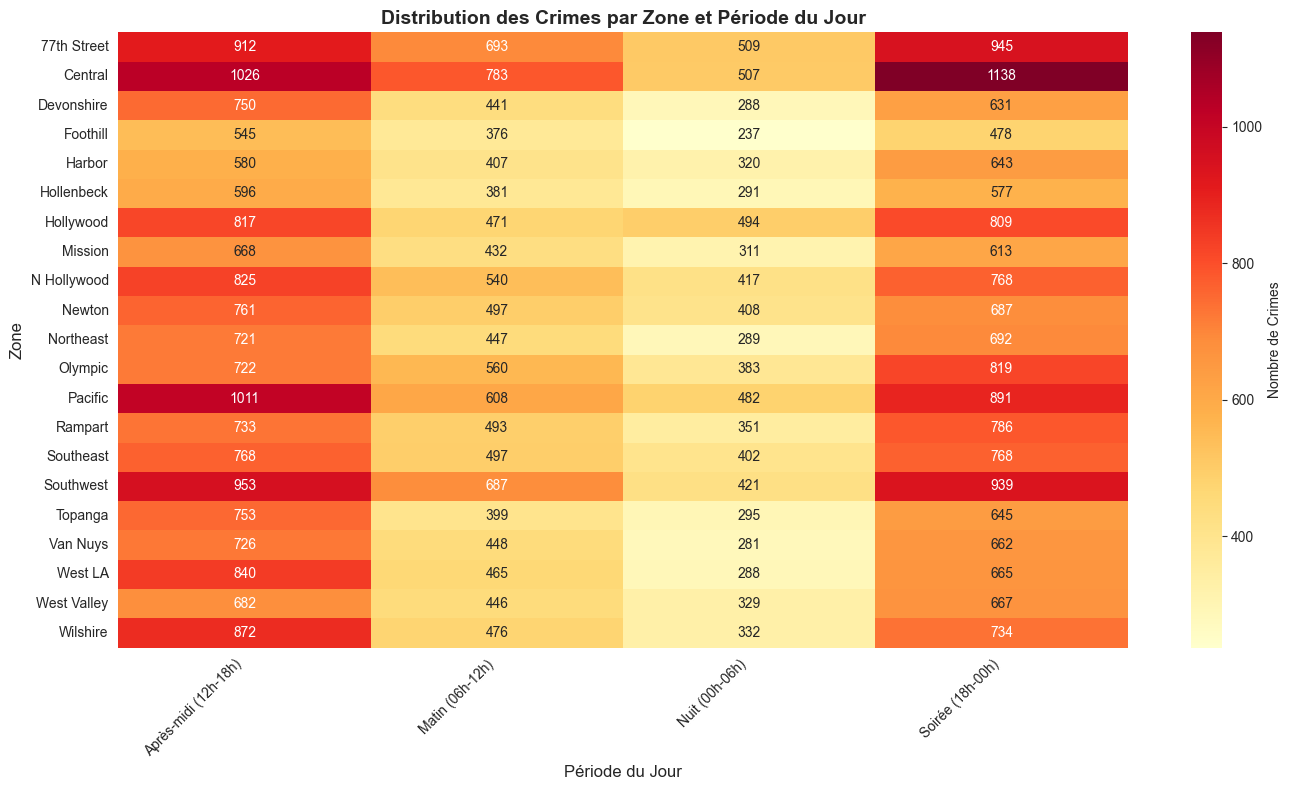


✓ Tableaux pivot créés avec succès


In [20]:
print("=" * 80)
print("TABLEAUX PIVOT")
print("=" * 80)

# Utiliser donnees_completes au lieu de df_complete
# Détecter les noms de colonnes
col_numero_dr = None
for possible_col in ['numero_rapport', 'DR_NO', 'dr_number']:
    if possible_col in donnees_completes.columns:
        col_numero_dr = possible_col
        break

col_age_vict = None
for possible_col in ['age_victime', 'Vict Age', 'victim_age']:
    if possible_col in donnees_completes.columns:
        col_age_vict = possible_col
        break

# 1. Pivot: Comptage des crimes par zone et période du jour
print("\n1. TABLEAU PIVOT - Crimes par Zone et Période du Jour:")
if col_numero_dr:
    pivot_temps = donnees_completes.pivot_table(
        values=col_numero_dr,
        index='AREA NAME',
        columns='periode_jour',
        aggfunc='count',
        fill_value=0
    )
else:
    # Utiliser size() si pas de colonne DR
    pivot_temps = donnees_completes.groupby(['AREA NAME', 'periode_jour']).size().unstack(fill_value=0)

print(pivot_temps)

# 2. Pivot: Âge moyen des victimes par catégorie de crime et zone
if col_age_vict:
    print("\n2. TABLEAU PIVOT - Âge Moyen des Victimes par Catégorie de Crime (Top 5 zones):")
    top_zones = donnees_completes['AREA NAME'].value_counts().head(5).index
    pivot_age = donnees_completes[donnees_completes['AREA NAME'].isin(top_zones)].pivot_table(
        values=col_age_vict,
        index='AREA NAME',
        columns='categorie_crime',
        aggfunc='mean',
        fill_value=0
    ).round(1)
    print(pivot_age)

# 3. Pivot avec agrégations multiples
print("\n3. TABLEAU PIVOT - Agrégations Multiples (Stats crimes par année et catégorie):")
if col_numero_dr:
    pivot_multi = donnees_completes.pivot_table(
        values=col_numero_dr,
        index='annee',
        columns='categorie_crime',
        aggfunc='count',
        fill_value=0
    )
else:
    pivot_multi = donnees_completes.groupby(['annee', 'categorie_crime']).size().unstack(fill_value=0)

print(pivot_multi.head())

# Visualiser le tableau pivot
print("\n4. VISUALISATION - Crimes par Période du Jour et Zone (Heatmap):")
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_temps, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Nombre de Crimes'})
plt.title('Distribution des Crimes par Zone et Période du Jour', fontsize=14, fontweight='bold')
plt.xlabel('Période du Jour', fontsize=12)
plt.ylabel('Zone', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Tableaux pivot créés avec succès")

### 5.2 Melt - Format Large vers Long

In [22]:
print("\n" + "=" * 80)
print("MELT - TRANSFORMATION FORMAT LARGE VERS LONG")
print("=" * 80)

# Créer un dataset format large avec les données trimestrielles
quarterly_wide = donnees_completes.groupby(['AREA NAME', 'trimestre']).size().unstack(fill_value=0)
quarterly_wide.columns = [f'T{int(col)}' for col in quarterly_wide.columns]
quarterly_wide = quarterly_wide.reset_index()

print("\n1. AVANT MELT (Format Large) - Crimes trimestriels par zone:")
print(quarterly_wide.head(10))
print(f"Forme: {quarterly_wide.shape}")

# Melt vers format long
quarterly_long = quarterly_wide.melt(
    id_vars=['AREA NAME'],
    value_vars=[col for col in quarterly_wide.columns if col.startswith('T')],
    var_name='Trimestre',
    value_name='Comptage_Crimes'
)

print("\n2. APRÈS MELT (Format Long):")
print(quarterly_long.head(20))
print(f"Forme: {quarterly_long.shape}")

# Détecter les noms de colonnes
col_numero_dr = None
for possible_col in ['numero_rapport', 'DR_NO', 'dr_number']:
    if possible_col in donnees_completes.columns:
        col_numero_dr = possible_col
        break

col_age_vict = None
for possible_col in ['age_victime', 'Vict Age', 'victim_age']:
    if possible_col in donnees_completes.columns:
        col_age_vict = possible_col
        break

# Autre exemple: Melt des données armes et victimes
if col_numero_dr and col_age_vict:
    crime_sample = donnees_completes[[col_numero_dr, 'AREA NAME', 'arme_impliquee', 'est_weekend', 
                                 col_age_vict]].head(1000).copy()
else:
    crime_sample = donnees_completes[['AREA NAME', 'arme_impliquee', 'est_weekend']].head(1000).copy()

print("\n3. AVANT MELT - Colonnes indicatrices multiples:")
print(crime_sample.head())

if col_numero_dr:
    crime_melted = crime_sample.melt(
        id_vars=[col_numero_dr, 'AREA NAME'],
        value_vars=['arme_impliquee', 'est_weekend'],
        var_name='Indicateur',
        value_name='Valeur'
    )
else:
    crime_melted = crime_sample.melt(
        id_vars=['AREA NAME'],
        value_vars=['arme_impliquee', 'est_weekend'],
        var_name='Indicateur',
        value_name='Valeur'
    )

print("\n4. APRÈS MELT - Indicateurs en lignes:")
print(crime_melted.head(10))
print(f"Forme originale: {crime_sample.shape} → Forme melted: {crime_melted.shape}")

print("\n✓ Opérations de melt terminées")


MELT - TRANSFORMATION FORMAT LARGE VERS LONG

1. AVANT MELT (Format Large) - Crimes trimestriels par zone:
     AREA NAME   T1   T2   T3   T4
0  77th Street  803  759  770  727
1      Central  905  831  865  853
2   Devonshire  576  489  520  525
3     Foothill  414  438  378  406
4       Harbor  486  504  517  443
5   Hollenbeck  478  438  453  476
6    Hollywood  726  656  631  578
7      Mission  550  501  487  486
8  N Hollywood  694  636  612  608
9       Newton  638  603  596  516
Forme: (21, 5)

2. APRÈS MELT (Format Long):
      AREA NAME Trimestre  Comptage_Crimes
0   77th Street        T1              803
1       Central        T1              905
2    Devonshire        T1              576
3      Foothill        T1              414
4        Harbor        T1              486
5    Hollenbeck        T1              478
6     Hollywood        T1              726
7       Mission        T1              550
8   N Hollywood        T1              694
9        Newton        T1       

### 5.3 Empiler et Désempiler

In [23]:
print("\n" + "=" * 80)
print("OPÉRATIONS STACK ET UNSTACK")
print("=" * 80)

# Créer des données multi-index pour la démonstration
crime_summary = donnees_completes.groupby(['AREA NAME', 'annee', 'categorie_crime']).size().unstack(fill_value=0)

print("\n1. AVANT STACK - Catégories de crimes en colonnes:")
print(crime_summary.head())
print(f"Forme: {crime_summary.shape}")

# Stack: Convertir colonnes en lignes
stacked_data = crime_summary.stack()
print("\n2. APRÈS STACK - Catégories de crimes en index:")
print(stacked_data.head(20))
print(f"Type: {type(stacked_data)}")

# Unstack: Convertir niveau d'index en colonnes
unstacked_data = stacked_data.unstack(level=0)  # Unstack AREA NAME
print("\n3. UNSTACK (level=0) - Zones en colonnes:")
print(unstacked_data.head())

# Unstack d'un niveau différent
unstacked_year = stacked_data.unstack(level='annee')
print("\n4. UNSTACK (level='annee') - Années en colonnes:")
print(unstacked_year.head(10))

# Exemple complexe: Multi-level stacking/unstacking
crime_time_area = donnees_completes.groupby(['AREA NAME', 'periode_jour', 'categorie_crime']).size().unstack(fill_value=0)
print("\n5. DONNÉES MULTI-NIVEAUX:")
print(crime_time_area.head(10))

# Stack pour convertir en format long
stacked_complex = crime_time_area.stack()
print("\n6. MULTI-NIVEAUX STACKÉ:")
print(stacked_complex.head(20))
print(f"Niveaux d'index: {stacked_complex.index.names}")

print("\n✓ Opérations stack/unstack terminées")


OPÉRATIONS STACK ET UNSTACK

1. AVANT STACK - Catégories de crimes en colonnes:
categorie_crime    Armes  Autre  Crime Violent  Lié aux Véhicules  Vandalisme  \
AREA NAME   annee                                                               
77th Street 2020      49     61            191                  0          68   
            2021      41     63            198                  2          58   
            2022      42     48            204                  2          43   
            2023      38     56            203                  1          34   
            2024      16     26             83                  2          28   

categorie_crime    Vol/Cambriolage  
AREA NAME   annee                   
77th Street 2020               285  
            2021               280  
            2022               392  
            2023               346  
            2024               199  
Forme: (106, 6)

2. APRÈS STACK - Catégories de crimes en index:
AREA NAME    annee  categor

## 6. Pipeline de Transformation Automatique <a id='6'></a>

Créer un pipeline automatique et réutilisable pour transformer les données.

In [24]:
class CrimeDataTransformer:
    """
    Automated pipeline for transforming crime data.
    Applies all transformation steps in a reproducible manner.
    """
    
    def __init__(self, df, demographics_df=None):
        """
        Initialize the transformer with data.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Raw crime data
        demographics_df : pd.DataFrame, optional
            Area demographics data for merging
        """
        self.df = df.copy()
        self.demographics_df = demographics_df
        self.transformed_df = None
        
    def create_temporal_features(self):
        """Create datetime-based features"""
        print("[1/6] Creating temporal features...")
        
        # Convert dates
        self.df['Date Rptd'] = pd.to_datetime(self.df['Date Rptd'], errors='coerce')
        self.df['DATE OCC'] = pd.to_datetime(self.df['DATE OCC'], errors='coerce')
        
        # Extract features
        self.df['year'] = self.df['DATE OCC'].dt.year
        self.df['month'] = self.df['DATE OCC'].dt.month
        self.df['month_name'] = self.df['DATE OCC'].dt.month_name()
        self.df['day_of_week'] = self.df['DATE OCC'].dt.dayofweek
        self.df['day_name'] = self.df['DATE OCC'].dt.day_name()
        self.df['quarter'] = self.df['DATE OCC'].dt.quarter
        
        # Time period
        self.df['hour'] = (self.df['TIME OCC'] // 100).astype(int)
        self.df['time_period'] = self.df['hour'].apply(self._get_time_period)
        
        # Weekend flag
        self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)
        
        # Reporting delay
        self.df['reporting_delay_days'] = (self.df['Date Rptd'] - self.df['DATE OCC']).dt.days
        
        print("   ✓ Temporal features created")
        return self
    
    def create_crime_features(self):
        """Create crime categorization features"""
        print("[2/6] Creating crime features...")
        
        # Crime severity
        self.df['crime_severity'] = self.df['Part 1-2'].map({
            1: 'Part 1 - Serious Crime',
            2: 'Part 2 - Less Serious Crime'
        })
        
        # Crime category
        self.df['crime_category'] = self.df['Crm Cd Desc'].apply(self._categorize_crime)
        
        # Weapon features
        self.df['weapon_involved'] = self.df['Weapon Desc'].apply(
            lambda x: 0 if pd.isna(x) or x == '' else 1
        )
        self.df['weapon_category'] = self.df['Weapon Desc'].apply(self._categorize_weapon)
        
        print("   ✓ Crime features created")
        return self
    
    def create_demographic_features(self):
        """Create victim and location features"""
        print("[3/6] Creating demographic features...")
        
        # Age groups
        self.df['victim_age_group'] = self.df['Vict Age'].apply(self._categorize_age)
        
        # Location types
        self.df['location_type'] = self.df['Premis Desc'].apply(self._categorize_location)
        
        # Area statistics
        area_counts = self.df.groupby('AREA NAME')['DR_NO'].transform('count')
        self.df['area_crime_frequency'] = area_counts
        max_freq = self.df['area_crime_frequency'].max()
        self.df['area_risk_score'] = (self.df['area_crime_frequency'] / max_freq * 100).round(2)
        
        print("   ✓ Demographic features created")
        return self
    
    def merge_supplementary_data(self):
        """Merge with supplementary datasets"""
        print("[4/6] Merging supplementary data...")
        
        if self.demographics_df is not None:
            self.df = self.df.merge(self.demographics_df, on='AREA NAME', how='left')
            
            # Calculate derived metrics
            if 'population' in self.df.columns:
                resolution_stats = self.df.groupby('AREA NAME').agg({
                    'DR_NO': 'count'
                }).reset_index()
                resolution_stats.columns = ['AREA NAME', 'total_cases']
                
                self.df = self.df.merge(resolution_stats, on='AREA NAME', how='left')
                self.df['crimes_per_1000'] = (
                    self.df['total_cases'] / self.df['population'] * 1000
                ).round(2)
            
            print("   ✓ Supplementary data merged")
        else:
            print("   ⚠ No supplementary data provided, skipping merge")
        
        return self
    
    def apply_filters(self, conditions=None):
        """Apply custom filters if provided"""
        print("[5/6] Applying filters...")
        
        if conditions is not None:
            initial_len = len(self.df)
            for condition_name, condition in conditions.items():
                self.df = self.df[condition(self.df)]
            print(f"   ✓ Filters applied: {initial_len:,} → {len(self.df):,} rows")
        else:
            print("   ⚠ No filters provided, skipping")
        
        return self
    
    def create_aggregations(self):
        """Create useful aggregated views"""
        print("[6/6] Creating aggregations...")
        
        # Store original transformed data
        self.transformed_df = self.df.copy()
        
        # Create pivot tables for analysis
        self.pivot_area_time = self.df.pivot_table(
            values='DR_NO',
            index='AREA NAME',
            columns='time_period',
            aggfunc='count',
            fill_value=0
        )
        
        self.pivot_category_year = self.df.pivot_table(
            values='DR_NO',
            index='crime_category',
            columns='year',
            aggfunc='count',
            fill_value=0
        )
        
        print("   ✓ Aggregations created")
        return self
    
    def transform(self, verbose=True):
        """Execute full transformation pipeline"""
        if verbose:
            print("=" * 80)
            print("EXECUTING AUTOMATED TRANSFORMATION PIPELINE")
            print("=" * 80)
            print(f"Initial shape: {self.df.shape}\n")
        
        self.create_temporal_features()
        self.create_crime_features()
        self.create_demographic_features()
        self.merge_supplementary_data()
        self.create_aggregations()
        
        if verbose:
            print("\n" + "=" * 80)
            print("TRANSFORMATION COMPLETED")
            print("=" * 80)
            print(f"Final shape: {self.df.shape}")
            print(f"New features added: {len(self.df.columns) - len(self.transformed_df.columns) if self.transformed_df is not None else 'N/A'}")
        
        return self.df
    
    @staticmethod
    def _get_time_period(hour):
        if pd.isna(hour):
            return 'Unknown'
        elif 0 <= hour < 6:
            return 'Late Night (00:00-05:59)'
        elif 6 <= hour < 12:
            return 'Morning (06:00-11:59)'
        elif 12 <= hour < 18:
            return 'Afternoon (12:00-17:59)'
        else:
            return 'Evening (18:00-23:59)'
    
    @staticmethod
    def _categorize_crime(description):
        if pd.isna(description):
            return 'Unknown'
        desc = str(description).upper()
        if any(w in desc for w in ['ASSAULT', 'BATTERY', 'HOMICIDE', 'MURDER', 'RAPE']):
            return 'Violent Crime'
        elif any(w in desc for w in ['THEFT', 'BURGLARY', 'ROBBERY', 'STOLEN', 'SHOPLIFTING']):
            return 'Property Crime'
        elif any(w in desc for w in ['VEHICLE', 'AUTO', 'CAR']):
            return 'Vehicle-Related'
        elif any(w in desc for w in ['FRAUD', 'IDENTITY', 'FORGERY']):
            return 'Fraud/Financial'
        elif 'VANDALISM' in desc:
            return 'Vandalism'
        elif any(w in desc for w in ['DRUG', 'NARCOTIC']):
            return 'Drug-Related'
        else:
            return 'Other'
    
    @staticmethod
    def _categorize_weapon(weapon_desc):
        if pd.isna(weapon_desc) or weapon_desc == '':
            return 'No Weapon'
        weapon_str = str(weapon_desc).upper()
        if any(w in weapon_str for w in ['GUN', 'FIREARM', 'PISTOL', 'REVOLVER']):
            return 'Firearm'
        elif any(w in weapon_str for w in ['KNIFE', 'BLADE']):
            return 'Blade/Knife'
        elif 'STRONG-ARM' in weapon_str or 'HANDS' in weapon_str:
            return 'Physical Force'
        else:
            return 'Other Weapon'
    
    @staticmethod
    def _categorize_age(age):
        if pd.isna(age) or age == 0:
            return 'Unknown'
        elif age < 13:
            return 'Child (0-12)'
        elif 13 <= age < 18:
            return 'Teen (13-17)'
        elif 18 <= age < 25:
            return 'Young Adult (18-24)'
        elif 25 <= age < 35:
            return 'Adult (25-34)'
        elif 35 <= age < 50:
            return 'Middle Age (35-49)'
        elif 50 <= age < 65:
            return 'Senior (50-64)'
        else:
            return 'Elderly (65+)'
    
    @staticmethod
    def _categorize_location(premise_desc):
        if pd.isna(premise_desc):
            return 'Unknown'
        premise_str = str(premise_desc).upper()
        if any(w in premise_str for w in ['STREET', 'SIDEWALK', 'ALLEY']):
            return 'Public Street'
        elif any(w in premise_str for w in ['DWELLING', 'RESIDENCE', 'HOUSE', 'APARTMENT']):
            return 'Residential'
        elif any(w in premise_str for w in ['STORE', 'SHOP', 'MARKET', 'MALL']):
            return 'Commercial'
        elif any(w in premise_str for w in ['PARKING', 'GARAGE']):
            return 'Parking Area'
        elif any(w in premise_str for w in ['SCHOOL', 'UNIVERSITY']):
            return 'Educational'
        else:
            return 'Other'

print("✓ CrimeDataTransformer class created successfully!")
print("\nUsage:")
print("  transformer = CrimeDataTransformer(df, demographics_df)")
print("  transformed_data = transformer.transform()")

✓ CrimeDataTransformer class created successfully!

Usage:
  transformer = CrimeDataTransformer(df, demographics_df)
  transformed_data = transformer.transform()


### 6.1 Tester le Pipeline Automatique

Montrer le pipeline sur des données fraîches.

In [ ]:
# Load fresh data
df_test = pd.read_csv('../data/Crime_Data_from_2020_to_Present_50k.csv')

# Create transformer instance with demographics
transformer = CrimeDataTransformer(df_test, donnees_demographiques)

# Execute transformation pipeline
df_final_transformed = transformer.transform(verbose=True)

print("\n" + "=" * 80)
print("PIPELINE OUTPUT SUMMARY")
print("=" * 80)
print(f"Total records: {len(df_final_transformed):,}")
print(f"Total columns: {len(df_final_transformed.columns)}")
print(f"\nNew columns created: {[col for col in df_final_transformed.columns if col not in df_test.columns]}")

FileNotFoundError: [Errno 2] No such file or directory: 'Crime_Data_from_2020_to_Present_50k.csv'

## 7. Résumé & Export des Données Transformées <a id='7'></a>

Résumer les transformations et exporter le dataset final.

In [24]:
print("=" * 80)
print("DATA TRANSFORMATION SUMMARY")
print("=" * 80)

print("\n📊 TRANSFORMATION OVERVIEW:")
print(f"   • Original columns: {len(df_test.columns)}")
print(f"   • Final columns: {len(df_final_transformed.columns)}")
print(f"   • New features created: {len(df_final_transformed.columns) - len(df_test.columns)}")

print("\n🕒 TEMPORAL FEATURES CREATED:")
temporal_features = ['year', 'month', 'month_name', 'day_of_week', 'day_name', 'quarter', 
                     'hour', 'time_period', 'is_weekend', 'reporting_delay_days']
print(f"   {', '.join(temporal_features)}")

print("\n🔍 CRIME CATEGORIZATION FEATURES:")
crime_features = ['crime_severity', 'crime_category', 'weapon_involved', 'weapon_category']
print(f"   {', '.join(crime_features)}")

print("\n👥 DEMOGRAPHIC & LOCATION FEATURES:")
demo_features = ['victim_age_group', 'location_type', 'area_crime_frequency', 'area_risk_score']
print(f"   {', '.join(demo_features)}")

if 'population' in df_final_transformed.columns:
    print("\n🏙️ MERGED SUPPLEMENTARY DATA:")
    merged_features = ['population', 'median_income', 'area_size_sq_miles', 'crimes_per_1000']
    print(f"   {', '.join(merged_features)}")

print("\n📈 TRANSFORMATION TECHNIQUES USED:")
print("   ✓ apply() - Custom functions for categorization")
print("   ✓ map() - Value mapping and transformations")
print("   ✓ transform() - Group-wise transformations")
print("   ✓ Boolean indexing - Complex filtering")
print("   ✓ loc[] & iloc[] - Position and label-based selection")
print("   ✓ merge() - Combining datasets")
print("   ✓ concat() - Concatenating DataFrames")
print("   ✓ pivot() & pivot_table() - Reshaping data")
print("   ✓ melt() - Wide to long format")
print("   ✓ stack() & unstack() - Index manipulation")

print("\n" + "=" * 80)
print("SAMPLE OF TRANSFORMED DATA")
print("=" * 80)
df_final_transformed[['DATE OCC', 'Crm Cd Desc', 'crime_category', 'time_period', 
                       'victim_age_group', 'location_type', 'weapon_category', 
                       'area_risk_score']].head(10)

DATA TRANSFORMATION SUMMARY

📊 TRANSFORMATION OVERVIEW:
   • Original columns: 28
   • Final columns: 51
   • New features created: 23

🕒 TEMPORAL FEATURES CREATED:
   year, month, month_name, day_of_week, day_name, quarter, hour, time_period, is_weekend, reporting_delay_days

🔍 CRIME CATEGORIZATION FEATURES:
   crime_severity, crime_category, weapon_involved, weapon_category

👥 DEMOGRAPHIC & LOCATION FEATURES:
   victim_age_group, location_type, area_crime_frequency, area_risk_score

🏙️ MERGED SUPPLEMENTARY DATA:
   population, median_income, area_size_sq_miles, crimes_per_1000

📈 TRANSFORMATION TECHNIQUES USED:
   ✓ apply() - Custom functions for categorization
   ✓ map() - Value mapping and transformations
   ✓ transform() - Group-wise transformations
   ✓ Boolean indexing - Complex filtering
   ✓ loc[] & iloc[] - Position and label-based selection
   ✓ merge() - Combining datasets
   ✓ concat() - Concatenating DataFrames
   ✓ pivot() & pivot_table() - Reshaping data
   ✓ melt() - W

,DATE OCC,Crm Cd Desc,crime_category,time_period,victim_age_group,location_type,weapon_category,area_risk_score
0,2020-10-01,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",Other,Evening (18:00-23:59),Middle Age (35-49),Residential,No Weapon,68.41
1,2021-07-03,THEFT OF IDENTITY,Property Crime,Evening (18:00-23:59),Middle Age (35-49),Public Street,No Weapon,61.49
2,2020-11-26,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Violent Crime,Afternoon (12:00-17:59),Middle Age (35-49),Parking Area,Firearm,88.56
3,2023-10-04,THEFT PLAIN - PETTY ($950 & UNDER),Property Crime,Morning (06:00-11:59),Senior (50-64),Other,No Weapon,47.37
4,2022-03-31,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Property Crime,Evening (18:00-23:59),Middle Age (35-49),Other,No Weapon,61.49
5,2024-02-29,INTIMATE PARTNER - SIMPLE ASSAULT,Violent Crime,Evening (18:00-23:59),Adult (25-34),Residential,Physical Force,68.41
6,2021-09-21,CRIMINAL THREATS - NO WEAPON DISPLAYED,Other,Afternoon (12:00-17:59),Child (0-12),Educational,Other Weapon,56.46
7,2021-08-18,INTIMATE PARTNER - SIMPLE ASSAULT,Violent Crime,Afternoon (12:00-17:59),Young Adult (18-24),Residential,Physical Force,68.41
8,2023-08-08,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,Property Crime,Afternoon (12:00-17:59),Middle Age (35-49),Public Street,No Weapon,61.49
9,2024-11-29,THEFT PLAIN - PETTY ($950 & UNDER),Property Crime,Afternoon (12:00-17:59),Young Adult (18-24),Residential,No Weapon,75.01



BEFORE vs AFTER TRANSFORMATION
        Metric  Before   After
    Total Rows  50,000  50,000
 Total Columns      28      51
    Data Types 3 types 5 types
Missing Values 278,248 278,248


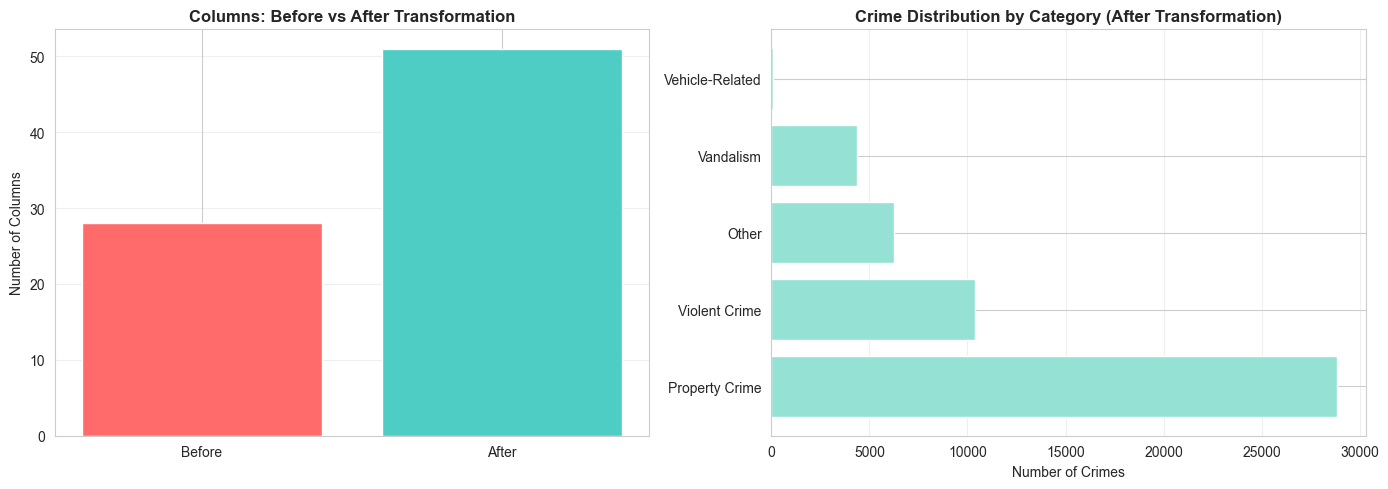


✓ Comparison completed


In [25]:
# Before and After Comparison
print("\n" + "=" * 80)
print("BEFORE vs AFTER TRANSFORMATION")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Total Rows', 'Total Columns', 'Data Types', 'Missing Values'],
    'Before': [
        f"{len(df_test):,}",
        len(df_test.columns),
        f"{len(df_test.dtypes.unique())} types",
        f"{df_test.isnull().sum().sum():,}"
    ],
    'After': [
        f"{len(df_final_transformed):,}",
        len(df_final_transformed.columns),
        f"{len(df_final_transformed.dtypes.unique())} types",
        f"{df_final_transformed.isnull().sum().sum():,}"
    ]
})

print(comparison_df.to_string(index=False))

# Visualize transformation impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Column count comparison
axes[0].bar(['Before', 'After'], [len(df_test.columns), len(df_final_transformed.columns)], 
           color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Number of Columns')
axes[0].set_title('Columns: Before vs After Transformation', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Crime category distribution
crime_cat_counts = df_final_transformed['crime_category'].value_counts()
axes[1].barh(crime_cat_counts.index, crime_cat_counts.values, color='#95E1D3')
axes[1].set_xlabel('Number of Crimes')
axes[1].set_title('Crime Distribution by Category (After Transformation)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Comparison completed")

In [26]:
# Export transformed data
output_filename = 'Crime_Data_Transformed.csv'
df_final_transformed.to_csv(output_filename, index=False)

print("\n" + "=" * 80)
print("EXPORT COMPLETE")
print("=" * 80)
print(f"✓ Transformed data saved to: '{output_filename}'")
print(f"   • Records: {len(df_final_transformed):,}")
print(f"   • Columns: {len(df_final_transformed.columns)}")
print(f"   • File ready for analysis and visualization!")

# Also save pivot tables
transformer.pivot_area_time.to_csv('Crime_Pivot_Area_Time.csv')
transformer.pivot_category_year.to_csv('Crime_Pivot_Category_Year.csv')
print(f"\n✓ Pivot tables also saved:")
print(f"   • Crime_Pivot_Area_Time.csv")
print(f"   • Crime_Pivot_Category_Year.csv")


EXPORT COMPLETE
✓ Transformed data saved to: 'Crime_Data_Transformed.csv'
   • Records: 50,000
   • Columns: 51
   • File ready for analysis and visualization!

✓ Pivot tables also saved:
   • Crime_Pivot_Area_Time.csv
   • Crime_Pivot_Category_Year.csv


---

## 🎯 Key Accomplishments in Data Transformation

### 1. **New Feature Creation** ✅
   - **Temporal Features:** Year, month, day, quarter, hour, time period, weekend indicator, reporting delay
   - **Crime Categories:** Severity levels, crime types, weapon involvement
   - **Demographics:** Age groups, location types, area risk scores
   - **Techniques Used:** `apply()`, `map()`, `transform()`

### 2. **Filtering and Selection** ✅
   - **Boolean Indexing:** Complex multi-condition filters
   - **loc[]:** Label-based indexing for specific rows/columns
   - **iloc[]:** Position-based indexing for sampling
   - **query():** SQL-like filtering syntax
   
### 3. **Merging and Concatenation** ✅
   - **Inner Merge:** Combined crime data with area demographics
   - **Left Merge:** Added resolution statistics
   - **Vertical Concatenation:** Combined data from different years
   - **Horizontal Concatenation:** Added area-level statistics
   
### 4. **Pivoting and Reshaping** ✅
   - **pivot_table():** Created cross-tabulations (area × time, category × year)
   - **melt():** Converted wide format to long format
   - **stack()/unstack():** Multi-level index manipulation
   - **Visual Analysis:** Heatmaps of pivoted data

### 5. **Automated Pipeline** ✅
   - **CrimeDataTransformer Class:** Complete reusable transformation pipeline
   - **Modular Design:** Each transformation step is a separate method
   - **Flexibility:** Can be customized with filters and supplementary data
   - **Reproducibility:** Same transformations can be applied to new data

---

## 📝 Transformation Statistics

| Transformation Type | Count | Examples |
|-------------------|-------|----------|
| **New Features** | 20+ | time_period, crime_category, victim_age_group, area_risk_score |
| **Boolean Filters** | 5+ | Violent crimes in 2024, Weekend weapon crimes, High-risk areas |
| **Merge Operations** | 3 | Demographics, Resolution stats, Seasonal patterns |
| **Pivot Tables** | 3 | Area×Time, Category×Year, Multi-level aggregations |
| **Reshaping Ops** | 4 | Melt, Stack, Unstack, Multiple indices |

---

## 🚀 Next Steps

The transformed dataset is now ready for:
1. **Exploratory Data Analysis (EDA)** - Discover patterns and insights
2. **Advanced Visualizations** - Create dashboards and interactive plots
3. **Statistical Analysis** - Hypothesis testing, correlation analysis
4. **Machine Learning** - Predictive modeling, clustering, classification
5. **Time Series Analysis** - Trend analysis, forecasting

---

## 💡 Most Interesting Parts for Presentation

1. **Automated Pipeline** - Showcase the CrimeDataTransformer class
2. **Crime Categorization** - Demonstrate intelligent crime grouping
3. **Time Period Analysis** - Show crime patterns by time of day
4. **Area Risk Scoring** - Highlight high-risk areas with merged demographics
5. **Interactive Pivots** - Display dynamic cross-tabulations
6. **Before/After Comparison** - Visual impact of transformations